In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import seaborn as sns

In [2]:
#seleção das colunas e tratramento dos dados
filme = pd.read_csv('movies_metadata.csv', low_memory = False)
filme = filme [['id','original_title','original_language','vote_count','genres','production_companies']]
filme.rename(columns = {'id':'ID_FILME','original_title':'TITULO','original_language':'LINGUAGEM','vote_count':'QT_AVALIACOES',
'genres':"GENEROS",'production_companies':'PRODUTORAS'}, inplace = True)


In [3]:
filme.dropna(inplace = True)
filme = filme[filme['QT_AVALIACOES'] > 999]
filme = filme[filme['LINGUAGEM'] == 'en']
filme['ID_FILME'] = filme['ID_FILME'].astype(int)

In [4]:
def get_genres_names(data: str) -> list:
    if isinstance(data, str):
        data = ast.literal_eval(data)
        names = [item['name'] for item in data]
        return names
    return []

def get_names(data: str) -> list:
    try:
        companies = ast.literal_eval(data)
        names = [company['name'] for company in companies]
        return names
    except (ValueError, TypeError):
        return []

In [5]:
filme['PRODUTORAS'] = filme['PRODUTORAS'].apply(get_names)
filme['GENEROS'] = filme['GENEROS'].apply(get_genres_names)

In [6]:
#juntando as colunas que serão usadas na criação do modelo de machine learning
filme['Infos'] = filme['GENEROS'] + (filme['PRODUTORAS'])

In [7]:
#uso do TF-IDF para transformação de uma matriz numerica
vec = TfidfVectorizer()
tfidf = vec.fit_transform(filme['Infos'].apply(lambda x: np.str_(x)))

In [8]:
#usando a similaridade do cosseno na matriz criada
sim = cosine_similarity(tfidf)

In [9]:
# transformando em um dataframe
sim_df2 = pd.DataFrame(sim, columns=filme['TITULO'], index=filme['TITULO'])
sim_df2.head()

TITULO,Toy Story,Jumanji,Heat,GoldenEye,Casino,Ace Ventura: When Nature Calls,Twelve Monkeys,Se7en,Pocahontas,The Usual Suspects,...,Power Rangers,Alien: Covenant,Baywatch,The Mummy,The Fate of the Furious,Baby Driver,Despicable Me 3,War for the Planet of the Apes,Dunkirk,Transformers: The Last Knight
TITULO,,,,,,,,,,,,,,,,,,,,,
Toy Story,1.000000,0.060926,0.000000,0.000000,0.000000,0.049504,0.000000,0.000000,0.372944,0.000000,...,0.000000,0.000000,0.024090,0.000000,0.000000,0.000000,0.421026,0.000000,0.000000,0.084308
Jumanji,0.060926,1.000000,0.000000,0.031569,0.008703,0.030343,0.014380,0.009846,0.078250,0.000000,...,0.027226,0.035701,0.007240,0.032072,0.059146,0.119879,0.109042,0.000000,0.025854,0.048247
Heat,0.000000,0.000000,1.000000,0.062565,0.049256,0.188017,0.031756,0.058364,0.023025,0.093373,...,0.024480,0.025696,0.013276,0.042651,0.112842,0.053307,0.035738,0.037445,0.125571,0.048278
GoldenEye,0.000000,0.031569,0.062565,1.000000,0.000000,0.071237,0.038248,0.026189,0.031474,0.082250,...,0.064897,0.080650,0.046912,0.079362,0.070784,0.041704,0.094743,0.000000,0.041027,0.089832
Casino,0.000000,0.008703,0.049256,0.000000,1.000000,0.037472,0.055304,0.032000,0.024270,0.045486,...,0.000000,0.000000,0.005294,0.040581,0.092536,0.031199,0.000000,0.025358,0.011075,0.017468


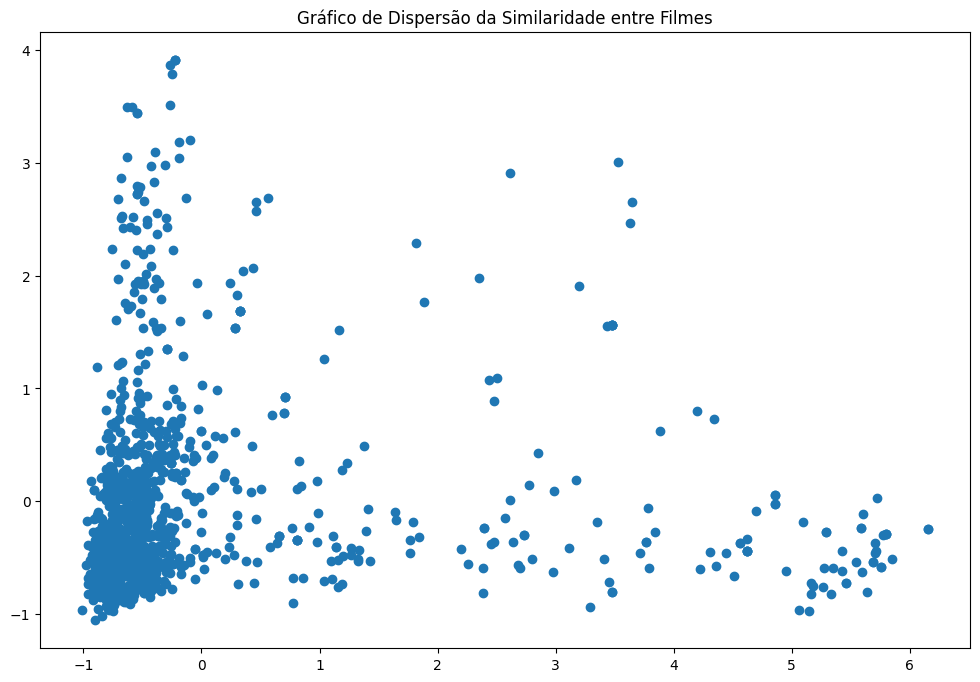

In [10]:
#fazendo o grafico de dispersão
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(sim)
plt.figure(figsize=(12, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title('Gráfico de Dispersão da Similaridade entre Filmes')
plt.show()

c:\Users\motal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


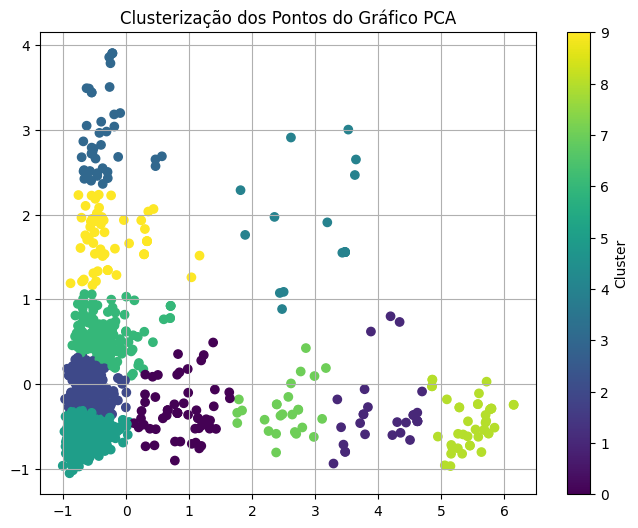

In [11]:
#criando o grafico de clusters
from sklearn.cluster import KMeans

num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# criando o K-Means com os pontos do gráfico PCA
cluster_labels = kmeans.fit_predict(pca_result)

# Adicione os rótulos de cluster aos dados
tfidf_com_clusters = pca_result.copy()
tfidf_com_clusters = tfidf_com_clusters.tolist()
for i in range(len(cluster_labels)):
    tfidf_com_clusters[i].append(cluster_labels[i])

# Converta os dados de volta para um formato NumPy
tfidf_com_clusters = np.array(tfidf_com_clusters)

# Plote os pontos do gráfico PCA coloridos por cluster
plt.figure(figsize=(8, 6))
plt.scatter(tfidf_com_clusters[:, 0], tfidf_com_clusters[:, 1], c=tfidf_com_clusters[:, 2], cmap='viridis')
plt.title("Clusterização dos Pontos do Gráfico PCA")
plt.colorbar(label="Cluster")
plt.grid()
plt.show()

In [12]:
#fazendo a filtragem paras recomendações
final_df = pd.DataFrame(sim_df2['Transformers: The Last Knight'].sort_values(ascending=False))
final_df.columns = ['Recomendações']
final_df.head(10)

,Recomendações
TITULO,
Transformers: The Last Knight,1.000000
Transformers: Dark of the Moon,0.724744
G.I. Joe: The Rise of Cobra,0.634734
Transformers: Revenge of the Fallen,0.576646
The Last Stand,0.558117
Transformers,0.507637
G.I. Joe: Retaliation,0.505454
Transformers: Age of Extinction,0.462812
Captain America: The First Avenger,0.439953
